In [8]:
# install pygame
# pip install pygame

# install ple
# git clone https://github.com/ntasfi/PyGame-Learning-Environment.git
# cd PyGame-Learning-Environment/
# pip install -e .

# install gym_ple
# pip install gym_ple

from collections import deque, namedtuple

In [1]:
%matplotlib inline
from Utils import Environment, SumTree
import os
 
import matplotlib
from matplotlib.pyplot import imshow, show
from collections import deque
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import warnings
warnings.filterwarnings('ignore')
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.__version__

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html
couldn't import doomish
Couldn't import doom


'1.0.0'

In [38]:
class Memory(object):  # stored as ( s, a, r, s_ ) in SumTree
    """
    This SumTree code is modified version and the original code is from:
    https://github.com/jaara/AI-blog/blob/master/Seaquest-DDQN-PER.py
    """
    PER_e = 0.01  # Hyperparameter that we use to avoid some experiences to have 0 probability of being taken
    PER_a = 0.6  # Hyperparameter that we use to make a tradeoff between taking only exp with high priority and sampling randomly
    PER_b = 0.4  # importance-sampling, from initial value increasing to 1
    
    PER_b_increment_per_sampling = 0.001
    
    absolute_error_upper = 1.  # clipped abs error

    def __init__(self, capacity):
        # Making the tree 
        """
        Remember that our tree is composed of a sum tree that contains the priority scores at his leaf
        And also a data array
        We don't use deque because it means that at each timestep our experiences change index by one.
        We prefer to use a simple array and to overwrite when the memory is full.
        """
        self.tree = SumTree(capacity)
        self.Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
        self.available = False
        
    """
    Store a new experience in our tree
    Each new experience have a score of max_prority (it will be then improved when we use this exp to train our DDQN)
    """
    def add(self, state, action, reward, next_state):
        # Find the max priority
        max_priority = np.max(self.tree.tree[-self.tree.capacity:])
        
        # If the max priority = 0 we can't put priority = 0 since this exp will never have a chance to be selected
        # So we use a minimum priority
        if max_priority == 0:
            max_priority = self.absolute_error_upper
        
        state = torch.FloatTensor([state])
        reward = torch.FloatTensor([reward])
        if next_state is not None:
            next_state = torch.FloatTensor(next_state)
        experience = self.Transition(state=state, action=action, reward=reward, next_state=next_state)
        self.tree.add(max_priority, experience)  # set the max p for new p

        
    """
    - First, to sample a minibatch of k size, the range [0, priority_total] is / into k ranges.
    - Then a value is uniformly sampled from each range
    - We search in the sumtree, the experience where priority score correspond to sample values are retrieved from.
    - Then, we calculate IS weights for each minibatch element
    """
    def sample(self, n):
        # Create a sample array that will contains the minibatch
        memory_b = []
        
        b_idx, b_ISWeights = np.empty((n,), dtype=np.int32), np.empty((n, 1), dtype=np.float32)
        
        # Calculate the priority segment
        # Here, as explained in the paper, we divide the Range[0, ptotal] into n ranges
        priority_segment = self.tree.total_priority / n       # priority segment
    
        # Here we increasing the PER_b each time we sample a new minibatch
        self.PER_b = np.min([1., self.PER_b + self.PER_b_increment_per_sampling])  # max = 1
        
        # Calculating the max_weight
        p_min = np.min(self.tree.tree[-self.tree.capacity:]) / self.tree.total_priority
        max_weight = (p_min * n) ** (-self.PER_b)
        
        for i in range(n):
            """
            A value is uniformly sample from each range
            """
            a, b = priority_segment * i, priority_segment * (i + 1)
            value = np.random.uniform(a, b)
            
            """
            Experience that correspond to each value is retrieved
            """
            index, priority, data = self.tree.get_leaf(value)
            
            #P(j)
            sampling_probabilities = priority / self.tree.total_priority
            
            #  IS = (1/N * 1/P(i))**b /max wi == (N*P(i))**-b  /max wi
            b_ISWeights[i, 0] = np.power(n * sampling_probabilities, -self.PER_b)/ max_weight
                                   
            b_idx[i]= index
            
            memory_b.append(data)
            
            sample = self.Transition(*(zip(*memory_b)))
        
        return b_idx, sample, b_ISWeights
    
    """
    Update the priorities on the tree
    """
    def batch_update(self, tree_idx, abs_errors):
        abs_errors += self.PER_e  # convert to abs and avoid 0
        clipped_errors = np.minimum(abs_errors, self.absolute_error_upper)
        ps = np.power(clipped_errors, self.PER_a)

        for ti, p in zip(tree_idx, ps):
            self.tree.update(ti, p)
            
    def is_ready(self):
        if self.available:
            return True
        else:
            prio_min = np.min(self.tree.tree[-self.tree.capacity:])
            self.available = prio_min != 0
            return self.available
        
        

In [39]:
env = Environment()
env.action_space, env.observation_space

(2, Box(512, 288, 3))

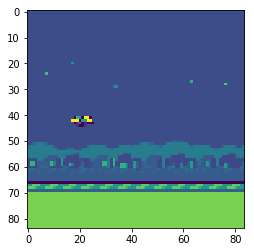

In [40]:
env.init()
env.step(1)
imshow(env.get_screen())

In [49]:
class DDDQN(nn.Module):
    def __init__(self):
        super(DDDQN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.value_fc = nn.Sequential(
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
        self.advantage_fc = nn.Sequential(
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, 2)
        )
#         self.fc2 = nn.Linear(512, 2)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        
        value_fc = self.value_fc(x)
        advantage_fc = self.advantage_fc(x)
        
        # Agregating layer
        # Q(s,a) = V(s) + (A(s,a) - 1/|A| * sum A(s,a'))
        output = value_fc + (advantage_fc - advantage_fc.mean(1,keepdim=True))
        return output
        

In [50]:
dddqn = DDDQN()
test = torch.randn(5,4,84,84)
dddqn(test).size()

torch.Size([5, 2])

In [71]:
class Agent(object):
    def __init__(self):
        self.env = Environment()
        self.dqn = DDDQN().to(device)
        self.target = DDDQN().to(device)
        self.target.load_state_dict(self.dqn.state_dict())
        self.target.eval()
        self.target_update_interval = 1000
#         self.optimizer = optim.RMSprop(self.dqn.parameters())
        self.optimizer = optim.Adam(self.dqn.parameters(), lr=0.0001)
        
        #play params
        self.play_interval = 1000
        self.play_repeat = 1
        self.best_steps_done = 0
        self.best_score = -1000
        
        self.seed = 111
        self.gamma = 0.99
        self.epsilon_start = 1.0
        self.epsilon_decay = 100000
        self.epsilon_stop = 0.01
        self.batch_size = 32
#         self.max_step = 1000
        self.global_steps = 0
        
        self.memory = Memory(10)

        self.frame_skipping = 4
        self.state_buffer_size = 4
        self.state_buffer = deque(maxlen=self.state_buffer_size)
        
    def save_checkpoint(self, filename='checkpoints/checkpoint.pth'):
        dirpath = os.path.dirname(filename)

        if not os.path.exists(dirpath):
            os.mkdir(dirpath)

        checkpoint = {
            'dqn': self.dqn.state_dict(),
            'target': self.target.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'global_steps': self.global_steps,
            'best_score': self.best_score,
            'best_steps_done': self.best_steps_done
        }
        torch.save(checkpoint, filename)
        
    def load_checkpoint(self, filename='checkpoints/checkpoint.pth'):
        checkpoint = torch.load(filename, map_location=device.type)
        self.dqn.load_state_dict(checkpoint['dqn'])
        self.target.load_state_dict(checkpoint['target'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.global_steps = checkpoint['global_steps']
        self.best_score = checkpoint['best_score']
        self.best_steps_done = checkpoint['best_steps_done']
        
        
    def play(self, human=True):
        self.env.reset()
        state = self.get_initial_state()
        steps_done = 0
        total_score = 0
        
        while True:

            state = torch.FloatTensor([state]).to(device)
            
            self.dqn.eval()
            action = self.dqn(state).cpu().max(1)[1]

            for _ in range(self.frame_skipping):
                if human:
                    screen = self.env.game.render(mode='human')
                _, reward, done, _ = self.env.step(action)

                next_state = self.env.get_screen()
                self.state_buffer.append(next_state)
                state = np.array(self.state_buffer)

                total_score += reward

                if done:
                    break

            steps_done += 1
            
            if done:
                self.dqn.train()
                break
        self.env.game.close()
        return total_score, steps_done

    def get_initial_state(self):
        self.env.reset()
        state = self.env.get_screen()
        
        self.state_buffer = deque(maxlen=self.state_buffer_size)
        [self.state_buffer.append(state) for _ in range(self.state_buffer_size)]
        return np.array(self.state_buffer)
    
    def optimize(self):
        tree_idx, transitions, ISWeights = self.memory.sample(n=self.batch_size)

        states = torch.cat(transitions.state).to(device)
        actions = torch.cat(transitions.action).to(device)
        rewards = torch.cat(transitions.reward).to(device)
        ISWeights = torch.FloatTensor(ISWeights, device=device)
        
        non_final_mask = torch.tensor(list(map(lambda s: s is not None, transitions.next_state)), 
                                      device=device, dtype=torch.uint8)
        non_final_next_states = torch.cat([s for s in transitions.next_state
                                            if s is not None])
        
        states = states.view([self.batch_size, self.state_buffer_size, self.env.width, self.env.height])

        q_values = self.dqn(states).gather(1, actions)
        
        target_values = torch.zeros(self.batch_size, device=device)
        non_final_next_states = non_final_next_states.view([-1, self.state_buffer_size, self.env.width, self.env.height]).to(device)
        target_values[non_final_mask] = self.target(non_final_next_states).max(1)[0].detach()
        
        expected_state_action_values = (target_values * self.gamma) + rewards
        
        # Update priority
        absolute_errors = torch.abs(expected_state_action_values.unsqueeze(1) - q_values).detach()
        self.memory.batch_update(tree_idx, absolute_errors)

        loss = torch.mean(ISWeights * F.mse_loss(q_values, expected_state_action_values.unsqueeze(1)))
                
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.dqn.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        
        
        reward_score = int(torch.sum(rewards).cpu().detach().numpy())
        
        return loss.cpu().detach().numpy(), reward_score


    def action(self, state):
        eps = self.epsilon_stop + (self.epsilon_start - self.epsilon_stop) * np.exp(-self.global_steps/self.epsilon_decay)
        if np.random.uniform() <= eps:
            state = torch.FloatTensor([state]).to(device)
            with torch.no_grad():
                return self.dqn(state).max(1)[1].view(-1,1).cpu(), eps
        else:
            sample_action = self.env.game.action_space.sample()
            action = torch.LongTensor([[sample_action]])
            return action, eps
        
    def train(self):
        
        while True:
            self.env.reset()
            state = self.get_initial_state()
            
            losses = []
            rewards = []
            steps_done = 0
            eps = self.epsilon_start
            
            done = False
            while not done:
                action, e = self.action(state)
                eps = e
                
                for _ in range(self.frame_skipping):
                    _, reward, done, _ = self.env.step(action.item())
                    next_state = self.env.get_screen()
                    self.state_buffer.append(next_state)
                    
                    if done:
                        break
            
            
                next_state = np.array(self.state_buffer)
                
                if done:
                    self.memory.add(state, action, reward, None)
                else:
                    self.memory.add(state, action, reward, next_state)

                state = next_state
                
                if self.memory.is_ready():
                    l, r = self.optimize()
                    losses.append(l)
                    rewards.append(r)

                steps_done += 1
                self.global_steps += 1
                
                # update target network
                if self.global_steps % self.target_update_interval == 0:
                    print('update target network!')
                    self.target.load_state_dict(self.dqn.state_dict())
              
                # Play
                if self.global_steps % self.play_interval == 0:
                    scores = []
                    total_steps_done = []
                    for _ in range(self.play_repeat):
                        score, steps_done = self.play(human=True)
                        scores.append(score)
                        total_steps_done.append(steps_done)
                        
                    real_score = int(np.mean(scores))
                    real_steps_done = int(np.mean(total_steps_done))

                    if self.best_steps_done <= real_steps_done:
                        self.best_score = real_score
                        self.best_steps_done = real_steps_done

                        self.save_checkpoint(
                            filename=f'dqn_checkpoints/chkpoint_{self.best_steps_done}_{self.best_score}.pth')

            if not np.isnan(np.mean(losses)):
                print('global_steps:%d, episode_steps:%d, loss:%.6f, rewards:%d, eps:%.6f'%(self.global_steps, steps_done, np.mean(losses), np.mean(rewards), eps))
                    

In [72]:
# training
agent = Agent() 

# agent.get_initial_state()[0].shape
agent.train()

global_steps:25, episode_steps:16, loss:0.988490, rewards:-16, eps:0.999762
global_steps:34, episode_steps:9, loss:1.689945, rewards:-31, eps:0.999673
global_steps:47, episode_steps:13, loss:1.084864, rewards:-26, eps:0.999545
global_steps:52, episode_steps:5, loss:1.568050, rewards:-30, eps:0.999495
global_steps:57, episode_steps:5, loss:1.897261, rewards:-35, eps:0.999446
global_steps:62, episode_steps:5, loss:2.278837, rewards:-41, eps:0.999396
global_steps:70, episode_steps:8, loss:1.497470, rewards:-30, eps:0.999317
global_steps:90, episode_steps:20, loss:0.844229, rewards:-10, eps:0.999119
global_steps:106, episode_steps:16, loss:1.193650, rewards:-14, eps:0.998961
global_steps:122, episode_steps:16, loss:0.368180, rewards:-17, eps:0.998803
global_steps:138, episode_steps:16, loss:0.585659, rewards:-16, eps:0.998645
global_steps:154, episode_steps:16, loss:0.625450, rewards:-15, eps:0.998486
global_steps:170, episode_steps:16, loss:0.285026, rewards:-13, eps:0.998328
global_steps

KeyboardInterrupt: 

In [10]:
# agent.save_checkpoint('dqn_checkpoints/exp_01.pth')

In [37]:
# # play
# agent = Agent()
# agent.load_checkpoint('dqn_checkpoints/chkpoint_771_76.pth')
# agent.play(human=True)


(15.0, 197)

In [ ]:
# references
# https://github.com/AndersonJo/dqn-pytorch/blob/master/dqn.py